In [1]:
# Dataloading Stuff
from google.colab import drive
import sys
import os
import operator
import collections
from importlib import reload


# Standard Stuff
!pip3 install numpy sklearn iterative-stratification pandas pyss3
from sklearn.model_selection import train_test_split
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from pyss3 import SS3
from pyss3.util import Dataset, Evaluation, span

import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
import pandas as pd

!pip3 install nltk
from nltk import word_tokenize, sent_tokenize, download
download('punkt')

drive.mount('/content/drive', force_remount=True)

     |████████████████████████████████| 2.0MB 3.7MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!rm -rf vocab_city 
!mkdir vocab_city

In [3]:
path_root = '/content/drive/My Drive/NLP Lab/SingleLabel'
vocab_root = '/Notebooks/Experiments/word-cloud/vocab_city'
sys.path.append(path_root)
data_root = '/data/'

In [4]:
import util

In [5]:
def retain_classes(text, labels, allowed_labels):
  indexes = []
  for c,value in enumerate(labels):
    if value not in allowed_labels:
      indexes.append(c)

  for index in sorted(indexes, reverse=True):
    del text[index]
    del labels[index]


def avg_important_word_number(samples, labels, vocab, threshold):
    size = 0
    for i, sample in enumerate(samples):
        
        # if(i%1000==0):
        #     print(i)
            
        df = vocab[labels[i] + '_' + 'words']
        for word in word_tokenize(sample):
            try:
                if df[df.term == word].iloc[0,3] > threshold:
                    size += 1
            except IndexError:
                    size += 0 
    return size / len(samples)

def __false_negative_words__(clf, categories, X_val, y_val, vocab):
    
    ## clf: model
    ## categories: list of classses
    ## X_val
    ## y_val
    ## vocab: dict of cat as keys and dataframe as vocab learned by the model for that class
    
    ## return
    ## fn_word: dict with keys as class and values as FN and word
    ##          FN: dict with keys as fals negative classes and all sentences and important words as keys
    ##          word: df of all fn_words with their gv and fn_class
    
    predict = clf.predict(X_val)
    fn_word = {}
    for cat in categories:
        class_vocab = vocab[cat+ "_words"].set_index('term', inplace=False)
        FN = collections.defaultdict(list)
        word = []
        for i, label in enumerate(y_val):
            if label == cat and predict[i] != cat:
                sentence = X_val[i].split()
                top_words = clf.extract_insight(X_val[i], predict[i],window_size=0)
                FN_word_sentence = []
                for top_word in list(set(top_words)):
                    insert = [X_val[i]]
                    insert.extend([top_word[0], top_word[1], predict[i], sentence.count(top_word[0])])
                    try:
                        # insert.append(class_vocab.loc[top_word[0], 'gv'])
                        insert.append(clf.cv(top_word[0].lower(), cat))
                    except KeyError:
                        insert.append("word not in vocab of "+ cat)
                    word.append(insert)
                    FN_word_sentence.append(insert)
                FN[predict[i]].append(FN_word_sentence)
        fn_word[cat] = (dict(FN),pd.DataFrame(word, columns =['sentence', 'fn_word', 'cv', 'fn_class', 'count', 'cv_trueclass']))
    return fn_word
    

In [6]:
with open(path_root + data_root + 'CityReview/test.txt', 'r') as text_file:
  text = text_file.read().split('\n')

with open(path_root + data_root + 'CityReview/test_label.txt', 'r') as label_file:
  labels = label_file.read().split('\n')
del text[-1]
del labels[-1]


reduce_class = 1
allowed_labels = ['Food', 'Staff', 'Price', 'Ambience', 'Anecdotes', 'Miscellaneous']
if reduce_class:
  retain_classes(text, labels, allowed_labels)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(text, labels, test_size=0.2)

Text(0, 0.5, '# of samples')

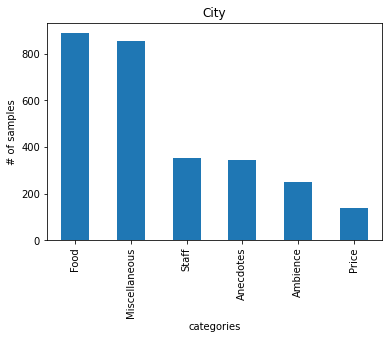

In [8]:
# pd.Series(labels).value_counts().plot(kind ='bar')
ax = pd.Series(labels).value_counts().plot(kind ='bar', title='City')
ax.set_xlabel("categories")
ax.set_ylabel("# of samples")

Classification: 100%|██████████| 566/566 [00:00<00:00, 26426.84it/s]



               precision    recall  f1-score   support

     Ambience       0.56      0.51      0.53        45
    Anecdotes       0.43      0.63      0.51        65
         Food       0.81      0.72      0.76       183
Miscellaneous       0.63      0.59      0.61       175
        Price       0.55      0.60      0.58        35
        Staff       0.65      0.67      0.66        63

     accuracy                           0.64       566
    macro avg       0.61      0.62      0.61       566
 weighted avg       0.66      0.64      0.65       566


 Accuracy: 0.641

[ updating evaluations cache ]


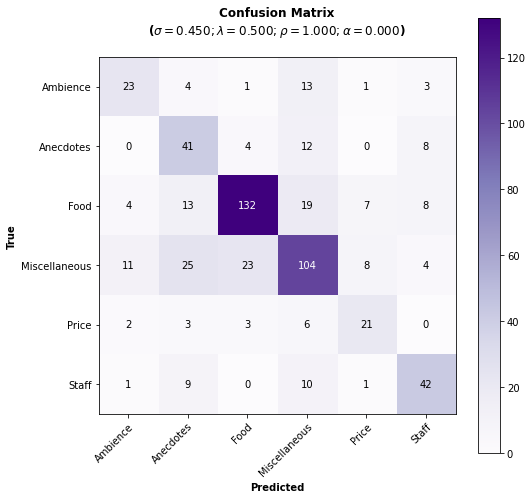

0.6092585480940669

In [10]:
clf = SS3(cv_m='gv')
clf.fit(X_train, y_train)
Evaluation.test(clf, X_val, y_val, metric="f1-score")